In [25]:
#Imports Bildverarbeitung
import numpy as np 
import cv2
from matplotlib import pyplot as plt
from skimage import exposure
from matplotlib.patches import Rectangle

#Imports Neuro
#import tensorflow as tf
#import keras
#from keras.models import Sequential
#from keras.layers import Dense #alle Neuronen sind miteinander verbunden
#from keras.optimizers import Adam
#from keras.utils import to_categorical
zaehler = 0

ModuleNotFoundError: No module named 'skimage'

In [11]:
def plot(bild):
    cv2.imshow('debugging',bild)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
##Bild einlesen und ausgeben lassen
def read_img(image):
    Bild_orig = cv2.imread('Bilder\\' + str(image), -1)
    return Bild_orig
    '''
    #Bild_Grau = cv2.imread('Bilder\sodoku1.jpg',0)
    #(tresh, Bild_bin) = cv2.threshold(Bild_Grau, 100, 200, cv2.THRESH_BINARY)

    #hoehe, breite = Bild_Grau.shape[:2]
    # '''

In [22]:
## Sodoku erkennen
def warping(image):
    Bild = np.array(image) 
    #plot(Bild_orig)

    # Kantendetektion mit Canny
    canny_output = cv2.Canny(Bild, 90, 200)
    #plot(canny_output)

    # Konturenfilterung anhand der berechneten Kanten
    #TODO algorithmus recherchieren opencv
    contours = None
    contours, _ = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    # cv2.RETR_TREE --> alle gefundenen Konturen werden gespeichert
    # cv2.CHAIN_APPROX_SIMPLE --> nur die Punkte von den Ecken werden gespeichert (mehrere, nicht nur vier, aber an den vier Ecken)

    # größtes rechteck finden
    index_groesstes = 0
    groesstes = cv2.contourArea(contours[index_groesstes])
    for i in range(1, len(contours)):
        a = cv2.contourArea(contours[i])  # Fläche der Rechtecke itterativ bestimmen
        if a > groesstes:
            groesstes=a
            index_groesstes = i; 

    # Koordinaten der Eckpunkte ermitteln quelle: https://www.geeksforgeeks.org/find-co-ordinates-of-contours-using-opencv-python/
    approx = cv2.approxPolyDP(contours[index_groesstes], 0.009 * cv2.arcLength(contours[index_groesstes], True), True)
    #Plot
    cv2.drawContours(Bild, [approx], 0, (0, 0, 255), 5) 
    #plot(Bild)

    # Bild perspektivisch verändern und zuschneiden quelle: https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/
    points = approx.reshape(4,2)
    rect = np.zeros((4, 2), dtype = "float32")

    summe = points.sum(axis = 1)
    rect[0] = points[np.argmin(summe)] #oben_links
    rect[2] = points[np.argmax(summe)] #unten_rechts
    differenz = np.diff(points, axis = 1)
    rect[1] = points[np.argmin(differenz)] #oben_rechts
    rect[3] = points[np.argmax(differenz)] #unten_links

    maxWidth = 270
    maxHeight = maxWidth

    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(Bild, M, (maxWidth, maxHeight))
    warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
    warp = exposure.rescale_intensity(warp, out_range = (0, 255))

    (h, w) = warp.shape
    #plot(warp)
    return warp

error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'Canny'
> Overload resolution failed:
>  - image data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'image'
>  - Canny() missing required argument 'threshold2' (pos 4)
>  - Canny() missing required argument 'threshold2' (pos 4)


In [14]:
## Einzelne Felder herausfiltern
# für weitere Berechnungen Binärbild
def teilbilder(image_warped):
    (tresh, Bild_bin) = cv2.threshold(image_warped, 100, 200, cv2.THRESH_BINARY)
    #plot(Bild_bin)
    breite_feld = int(maxWidth/9)
    hoehe_feld = breite_feld
    y_akt = 0
    x_akt = 0
    felder_bild = []

    for zeile in range(9):
        felder_bild.append([])
        for spalte in range(9):
            akt_bild = np.copy(Bild_bin[y_akt:y_akt+hoehe_feld, x_akt:x_akt+breite_feld])
            zaehler += 1
            felder_bild[zeile].append([akt_bild])
            x_akt = x_akt + breite_feld
        y_akt = y_akt + hoehe_feld
        x_akt = 0
    #plot(felder_bild[8][0][0])
    return felder_bild


In [15]:
## Trainingsdaten für Neuro generieren
def train_gen(image_warped):
    global zaehler
    (tresh, Bild_bin) = cv2.threshold(image_warped, 100, 200, cv2.THRESH_BINARY)
    #plot(Bild_bin)
    breite_feld = int(270/9)
    hoehe_feld = breite_feld
    y_akt = 0
    x_akt = 0
    felder_bild = []

    for zeile in range(9):
        felder_bild.append([])
        for spalte in range(9):
            akt_bild = np.copy(Bild_bin[y_akt:y_akt+hoehe_feld, x_akt:x_akt+breite_feld])
            filename = r'C:\Users\Johanna\Documents\Repos\sodoku\Ziffern\Bild' + str(zaehler) + r'.png'
            cv2.imwrite(filename, akt_bild)
            zaehler += 1
            felder_bild[zeile].append([akt_bild])
            x_akt = x_akt + breite_feld
        y_akt = y_akt + hoehe_feld
        x_akt = 0

In [24]:
## Trainingsdaten erzeugen
pic = read_img('handy\sodoku12.jpg')
warp = warping(pic)
plot(warp)
# train_gen(warp)

NameError: name 'exposure' is not defined

In [17]:
def geloest(matrix):
    for zeile in range(9):
        for spalte in range(9):
            pass
            

In [18]:
def leeresSodoku():
    someX, someY = 0.5, 0.5
    plt.figure()
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((someX - .1, someY - .1), 10, 10, fill=None, alpha=1))
    plt.show()

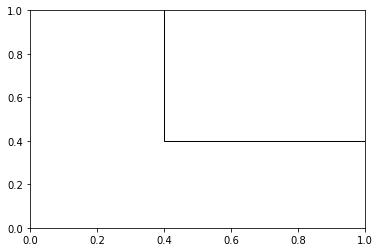

In [19]:
leeresSodoku()

In [20]:
#zahlen analysieren
#hier auch noch eventuelle rotation beachten
#sodoku algo
#zahlen ausfüllen

In [21]:
## Neuronales Netz zur Zahlenerkennung quelle: http://python-programmieren.maximilianwittmann.de/kunstliche-intelligenz-programmieren/

#Imports
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense #alle Neuronen sind miteinander verbunden
from keras.optimizers import Adam
from keras.utils import to_categorical

#70000 Datensätze aus der Keras Bib (28 x 28 Pixel)
mnist = keras.datasets.mnist
#Trennung in Trainings- und Testdaten
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train  = keras.utils.normalize(x_train, axis=1)
x_test  = keras.utils.normalize(x_test, axis=1)

# 2 Hidden Layers, je 128 Neuronen
model = Sequential()
model.add(Dense(128, activation='relu')) # Hidden Layer 1
model.add(Dense(128, activation='relu')) # Hidden Layer 2
model.add(Dense(10, activation='softmax')) # Output Layer

model.compile(
    optimizer='rmsprop' 
)

model.fit(
    x_train.reshape(60000, 784), 
    y_train, 
    batch_size=64, 
    epochs=3
)






ModuleNotFoundError: No module named 'tensorflow'